### Tacotron2 Implementation Reference

https://github.com/NVIDIA/tacotron2

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from easydict import EasyDict

In [2]:
from hparams import hparams
print(hparams)

{'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 80.0, 'mel_fmax': 7600.0, 'n_symbols': 256, 'symbols_embedding_dim': 512, 'encoder_kernel_size': 5, 'encoder_n_convolutions': 3, 'encoder_embedding_dim': 512, 'n_frames_per_step': 1, 'decoder_rnn_dim': 1024, 'prenet_dim': 256, 'max_decoder_steps': 1000, 'gate_threshold': 0.5, 'p_attention_dropout': 0.1, 'p_decoder_dropout': 0.1, 'attention_rnn_dim': 1024, 'attention_dim': 128, 'attention_location_n_filters': 32, 'attention_location_kernel_size': 31, 'postnet_embedding_dim': 512, 'postnet_kernel_size': 5, 'postnet_n_convolutions': 5, 'mask_padding': True}


### Attention Layer

attention_weights_cat : concatenation of accumulated attention weight and previous attention weight

In [3]:
class LocationLayer(nn.Module):
    def __init__(self, attention_n_filters, attention_kernel_size,
                 attention_dim):
        super(LocationLayer, self).__init__()
        padding = int((attention_kernel_size - 1) / 2)
        self.location_conv = nn.Conv1d(2, attention_n_filters,
                                      kernel_size=attention_kernel_size,
                                      padding=padding, bias=False, stride=1,
                                      dilation=1)
        self.location_dense = nn.Linear(attention_n_filters, attention_dim, bias=False)

    def forward(self, attention_weights_cat):
        # attention_weights_cat : (batch, 2, length)
        
        # (batch, dim, length)
        processed_attention = self.location_conv(attention_weights_cat)
        # (batch, length, dim)
        processed_attention = processed_attention.transpose(1, 2)
        # (batch, length, dim)
        processed_attention = self.location_dense(processed_attention)
        return processed_attention


In [4]:
location_layer = LocationLayer(32, 31, 512)
t = torch.randn(2, 2, 1024)
t = location_layer(t)
print(t.shape)

torch.Size([2, 1024, 512])


### Attention

In [5]:
class Attention(nn.Module):
    def __init__(self, attention_rnn_dim, embedding_dim, attention_dim,
                 attention_location_n_filters, attention_location_kernel_size):
        super(Attention, self).__init__()
        self.query_layer = nn.Linear(attention_rnn_dim, attention_dim, bias=False)
        self.memory_layer = nn.Linear(embedding_dim, attention_dim, bias=False)
        self.v = nn.Linear(attention_dim, 1, bias=False)
        self.location_layer = LocationLayer(attention_location_n_filters,
                                            attention_location_kernel_size,
                                            attention_dim)
        self.score_mask_value = -float("inf")

    def get_alignment_energies(self, query, processed_memory,
                               attention_weights_cat):
        """
        PARAMS
        ------
        query: decoder output (batch, n_mel_channels * n_frames_per_step)
        processed_memory: processed encoder outputs (B, T_in, attention_dim)
        attention_weights_cat: cumulative and prev. att weights (B, 2, max_time)
        RETURNS
        -------
        alignment (batch, max_time)
        """

        # (batch, 1, channel)
        processed_query = self.query_layer(query.unsqueeze(1))
        # (batch, length, channel)
        processed_attention_weights = self.location_layer(attention_weights_cat)
        # (batch, length, channel)
        processed_memory
        # (batch, length, 1)
        energies = self.v(torch.tanh(
            processed_query + processed_attention_weights + processed_memory))

        # (batch, length)
        energies = energies.squeeze(-1)
        return energies

    def forward(self, attention_hidden_state, memory, processed_memory,
                attention_weights_cat, mask):
        """
        PARAMS
        ------
        attention_hidden_state: attention rnn last output
        memory: encoder outputs
        processed_memory: processed encoder outputs
        attention_weights_cat: previous and cummulative attention weights
        mask: binary mask for padded data
        """
        # (batch, length)
        alignment = self.get_alignment_energies(
            attention_hidden_state, processed_memory, attention_weights_cat)

        if mask is not None:
            alignment.data.masked_fill_(mask, self.score_mask_value)

        attention_weights = F.softmax(alignment, dim=1)
        attention_context = torch.bmm(attention_weights.unsqueeze(1), memory)
        attention_context = attention_context.squeeze(1)

        return attention_context, attention_weights    

In [6]:
attention = Attention(512, 512, 512, 32, 31)

B, L = 2, 100
attention_hidden_state = torch.randn(B, 512)
memory = torch.randn(B, L, 512)
processed_memory = torch.randn(B, L, 512)
attention_weights_cat = torch.randn(B, 2, L)
attention_context, attention_weights = attention(attention_hidden_state, memory, processed_memory, attention_weights_cat, None)
print(attention_context.shape)
print(attention_weights.shape)


torch.Size([2, 512])
torch.Size([2, 100])


### Prenet & Postnet

In [7]:
class Prenet(nn.Module):
    def __init__(self, in_dim, sizes):
        super(Prenet, self).__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size, bias=False)
             for (in_size, out_size) in zip(in_sizes, sizes)])

    def forward(self, x):
        for linear in self.layers:
            x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
        return x

In [8]:
prenet = Prenet(in_dim=512, sizes=[256, 256])
t = torch.randn(2, 512)
t = prenet(t)
print(t.shape)

torch.Size([2, 256])


In [9]:
class Postnet(nn.Module):
    """Postnet
        - Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self, hparams):
        super(Postnet, self).__init__()
        self.convolutions = nn.ModuleList()

        self.convolutions.append(
            nn.Sequential(
                nn.Conv1d(hparams.n_mel_channels, hparams.postnet_embedding_dim,
                         kernel_size=hparams.postnet_kernel_size, stride=1,
                         padding=int((hparams.postnet_kernel_size - 1) / 2),
                         dilation=1),
                nn.BatchNorm1d(hparams.postnet_embedding_dim))
        )

        for i in range(1, hparams.postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    nn.Conv1d(hparams.postnet_embedding_dim,
                             hparams.postnet_embedding_dim,
                             kernel_size=hparams.postnet_kernel_size, stride=1,
                             padding=int((hparams.postnet_kernel_size - 1) / 2),
                             dilation=1),
                    nn.BatchNorm1d(hparams.postnet_embedding_dim))
            )

        self.convolutions.append(
            nn.Sequential(
                nn.Conv1d(hparams.postnet_embedding_dim, hparams.n_mel_channels,
                         kernel_size=hparams.postnet_kernel_size, stride=1,
                         padding=int((hparams.postnet_kernel_size - 1) / 2),
                         dilation=1),
                nn.BatchNorm1d(hparams.n_mel_channels))
            )

    def forward(self, x):
        # x : (batch, channel, time)
        
        for i in range(len(self.convolutions) - 1):
            x = F.dropout(torch.tanh(self.convolutions[i](x)), 0.5, self.training)
        x = F.dropout(self.convolutions[-1](x), 0.5, self.training)

        return x

In [10]:
postnet = Postnet(hparams)
t = torch.randn(2, 80, 1024)
t = postnet(t)
print(t.shape)

torch.Size([2, 80, 1024])


### Text Encoder

In [11]:
class Encoder(nn.Module):
    """Encoder module:
        - Three 1-d convolution banks
        - Bidirectional LSTM
    """
    def __init__(self, hparams):
        super(Encoder, self).__init__()

        convolutions = []
        for _ in range(hparams.encoder_n_convolutions):
            conv_layer = nn.Sequential(
                nn.Conv1d(hparams.encoder_embedding_dim,
                         hparams.encoder_embedding_dim,
                         kernel_size=hparams.encoder_kernel_size, stride=1,
                         padding=int((hparams.encoder_kernel_size - 1) / 2),
                         dilation=1),
                nn.BatchNorm1d(hparams.encoder_embedding_dim))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(hparams.encoder_embedding_dim,
                            int(hparams.encoder_embedding_dim / 2), 1,
                            batch_first=True, bidirectional=True)

    def forward(self, x, input_lengths):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        # pytorch tensor are not reversible, hence the conversion
        input_lengths = input_lengths.cpu().numpy()
        x = nn.utils.rnn.pack_padded_sequence(x, input_lengths, batch_first=True, enforce_sorted=False)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        return outputs

    def inference(self, x):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs

In [12]:
encoder = Encoder(hparams)

t = torch.randn(2, 512, 100)
t_lengths = torch.LongTensor(np.array([57, 80]))
t = encoder(t, t_lengths)
print(t.shape)

torch.Size([2, 80, 512])


In [13]:
t = torch.randn(1, 512, 100)
t = encoder.inference(t)
print(t.shape)

torch.Size([1, 100, 512])


### Mel Decoder

In [14]:
def get_mask_from_lengths(lengths):
        max_len = torch.max(lengths).item()
        ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
        mask = (ids < lengths.unsqueeze(1)).bool()
        return mask
    
class Decoder(nn.Module):
    def __init__(self, hparams):
        super(Decoder, self).__init__()
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step = hparams.n_frames_per_step
        self.encoder_embedding_dim = hparams.encoder_embedding_dim
        self.attention_rnn_dim = hparams.attention_rnn_dim
        self.decoder_rnn_dim = hparams.decoder_rnn_dim
        self.prenet_dim = hparams.prenet_dim
        self.max_decoder_steps = hparams.max_decoder_steps
        self.gate_threshold = hparams.gate_threshold
        self.p_attention_dropout = hparams.p_attention_dropout
        self.p_decoder_dropout = hparams.p_decoder_dropout

        self.prenet = Prenet(
            hparams.n_mel_channels * hparams.n_frames_per_step,
            [hparams.prenet_dim, hparams.prenet_dim])

        self.attention_rnn = nn.LSTMCell(
            hparams.prenet_dim + hparams.encoder_embedding_dim,
            hparams.attention_rnn_dim)

        self.attention_layer = Attention(
            hparams.attention_rnn_dim, hparams.encoder_embedding_dim,
            hparams.attention_dim, hparams.attention_location_n_filters,
            hparams.attention_location_kernel_size)

        self.decoder_rnn = nn.LSTMCell(
            hparams.attention_rnn_dim + hparams.encoder_embedding_dim,
            hparams.decoder_rnn_dim, 1)

        self.linear_projection = nn.Linear(
            hparams.decoder_rnn_dim + hparams.encoder_embedding_dim,
            hparams.n_mel_channels * hparams.n_frames_per_step)

        self.gate_layer = nn.Linear(
            hparams.decoder_rnn_dim + hparams.encoder_embedding_dim, 1,
            bias=True)

    def get_go_frame(self, memory):
        """ Gets all zeros frames to use as first decoder input
        PARAMS
        ------
        memory: decoder outputs
        RETURNS
        -------
        decoder_input: all zeros frames
        """
        B = memory.size(0)
        decoder_input = Variable(memory.data.new(
            B, self.n_mel_channels * self.n_frames_per_step).zero_())
        return decoder_input

    def initialize_decoder_states(self, memory, mask):
        """ Initializes attention rnn states, decoder rnn states, attention
        weights, attention cumulative weights, attention context, stores memory
        and stores processed memory
        PARAMS
        ------
        memory: Encoder outputs
        mask: Mask for padded data if training, expects None for inference
        """
        B = memory.size(0)
        MAX_TIME = memory.size(1)

        self.attention_hidden = Variable(memory.data.new(
            B, self.attention_rnn_dim).zero_())
        self.attention_cell = Variable(memory.data.new(
            B, self.attention_rnn_dim).zero_())

        self.decoder_hidden = Variable(memory.data.new(
            B, self.decoder_rnn_dim).zero_())
        self.decoder_cell = Variable(memory.data.new(
            B, self.decoder_rnn_dim).zero_())

        self.attention_weights = Variable(memory.data.new(
            B, MAX_TIME).zero_())
        self.attention_weights_cum = Variable(memory.data.new(
            B, MAX_TIME).zero_())
        self.attention_context = Variable(memory.data.new(
            B, self.encoder_embedding_dim).zero_())

        self.memory = memory
        self.processed_memory = self.attention_layer.memory_layer(memory)
        self.mask = mask

    def parse_decoder_inputs(self, decoder_inputs):
        """ Prepares decoder inputs, i.e. mel outputs
        PARAMS
        ------
        decoder_inputs: inputs used for teacher-forced training, i.e. mel-specs
        RETURNS
        -------
        inputs: processed decoder inputs
        """
        # (B, n_mel_channels, T_out) -> (B, T_out, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(1, 2)
        decoder_inputs = decoder_inputs.view(
            decoder_inputs.size(0),
            int(decoder_inputs.size(1)/self.n_frames_per_step), -1)
        # (B, T_out, n_mel_channels) -> (T_out, B, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(0, 1)
        return decoder_inputs

    def parse_decoder_outputs(self, mel_outputs, gate_outputs, alignments):
        """ Prepares decoder outputs for output
        PARAMS
        ------
        mel_outputs:
        gate_outputs: gate output energies
        alignments:
        RETURNS
        -------
        mel_outputs:
        gate_outpust: gate output energies
        alignments:
        """
        # (T_out, B) -> (B, T_out)
        alignments = torch.stack(alignments).transpose(0, 1)
        # (T_out, B) -> (B, T_out)
        gate_outputs = torch.stack(gate_outputs).transpose(0, 1)
        gate_outputs = gate_outputs.contiguous()
        # (T_out, B, n_mel_channels) -> (B, T_out, n_mel_channels)
        mel_outputs = torch.stack(mel_outputs).transpose(0, 1).contiguous()
        # decouple frames per step
        mel_outputs = mel_outputs.view(
            mel_outputs.size(0), -1, self.n_mel_channels)
        # (B, T_out, n_mel_channels) -> (B, n_mel_channels, T_out)
        mel_outputs = mel_outputs.transpose(1, 2)

        return mel_outputs, gate_outputs, alignments

    def decode(self, decoder_input):
        """ Decoder step using stored states, attention and memory
        PARAMS
        ------
        decoder_input: previous mel output
        RETURNS
        -------
        mel_output:
        gate_output: gate output energies
        attention_weights:
        """
        cell_input = torch.cat((decoder_input, self.attention_context), -1)
        self.attention_hidden, self.attention_cell = self.attention_rnn(
            cell_input, (self.attention_hidden, self.attention_cell))
        self.attention_hidden = F.dropout(
            self.attention_hidden, self.p_attention_dropout, self.training)

        attention_weights_cat = torch.cat(
            (self.attention_weights.unsqueeze(1),
             self.attention_weights_cum.unsqueeze(1)), dim=1)
        self.attention_context, self.attention_weights = self.attention_layer(
            self.attention_hidden, self.memory, self.processed_memory,
            attention_weights_cat, self.mask)

        self.attention_weights_cum += self.attention_weights
        decoder_input = torch.cat(
            (self.attention_hidden, self.attention_context), -1)
        self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
            decoder_input, (self.decoder_hidden, self.decoder_cell))
        self.decoder_hidden = F.dropout(
            self.decoder_hidden, self.p_decoder_dropout, self.training)

        decoder_hidden_attention_context = torch.cat(
            (self.decoder_hidden, self.attention_context), dim=1)
        decoder_output = self.linear_projection(
            decoder_hidden_attention_context)

        gate_prediction = self.gate_layer(decoder_hidden_attention_context)
        return decoder_output, gate_prediction, self.attention_weights
    
    def forward(self, memory, decoder_inputs, memory_lengths):
        """ Decoder forward pass for training
        PARAMS
        ------
        memory: Encoder outputs
        decoder_inputs: Decoder inputs for teacher forcing. i.e. mel-specs
        memory_lengths: Encoder output lengths for attention masking.
        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """

        decoder_input = self.get_go_frame(memory).unsqueeze(0)
        decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
        decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
        decoder_inputs = self.prenet(decoder_inputs)

        self.initialize_decoder_states(
            memory, mask=~get_mask_from_lengths(memory_lengths))

        mel_outputs, gate_outputs, alignments = [], [], []
        while len(mel_outputs) < decoder_inputs.size(0) - 1:
            decoder_input = decoder_inputs[len(mel_outputs)]
            mel_output, gate_output, attention_weights = self.decode(
                decoder_input)
            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output.squeeze(1)]
            alignments += [attention_weights]

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments
    
    def inference(self, memory):
        """ Decoder inference
        PARAMS
        ------
        memory: Encoder outputs
        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        decoder_input = self.get_go_frame(memory)

        self.initialize_decoder_states(memory, mask=None)

        mel_outputs, gate_outputs, alignments = [], [], []
        while True:
            decoder_input = self.prenet(decoder_input)
            mel_output, gate_output, alignment = self.decode(decoder_input)

            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output]
            alignments += [alignment]

            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            elif len(mel_outputs) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break

            decoder_input = mel_output

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments

In [15]:
decoder = Decoder(hparams).cuda()

B, T, L = 2, 1024, 100
memory = torch.randn(B, L, 512).cuda()
memory_lengths = torch.LongTensor(np.array([90, 100])).cuda()
decoder_inputs = torch.randn(B, 80, T).cuda()
mel_outputs, gate_outputs, alignments = decoder(memory, decoder_inputs, memory_lengths)
print(mel_outputs.shape)
print(gate_outputs.shape)
print(alignments.shape)


torch.Size([2, 80, 1024])
torch.Size([2, 1024])
torch.Size([2, 1024, 100])


### Tacotron Main

In [16]:

class Tacotron2(nn.Module):
    def __init__(self, hparams):
        super(Tacotron2, self).__init__()
        self.mask_padding = hparams.mask_padding
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step = hparams.n_frames_per_step
        self.embedding = nn.Embedding(
            hparams.n_symbols, hparams.symbols_embedding_dim)
        
        from math import sqrt
        std = sqrt(2.0 / (hparams.n_symbols + hparams.symbols_embedding_dim))
        val = sqrt(3.0) * std  # uniform bounds for std
        self.embedding.weight.data.uniform_(-val, val)
        self.encoder = Encoder(hparams)
        self.decoder = Decoder(hparams)
        self.postnet = Postnet(hparams)

    def parse_batch(self, batch):
        text_padded, input_lengths, mel_padded, gate_padded, \
            output_lengths, _ = batch
        text_padded = text_padded.cuda().long()
        input_lengths = input_lengths.cuda().long()
        max_len = torch.max(input_lengths.data).item()
        mel_padded = mel_padded.cuda().float()
        gate_padded = gate_padded.cuda().float()
        output_lengths = output_lengths.cuda().long()

        return (
            (text_padded, input_lengths, mel_padded, max_len, output_lengths),
            (mel_padded, gate_padded))

    def parse_output(self, outputs, output_lengths=None):
        if self.mask_padding and output_lengths is not None:
            mask = ~get_mask_from_lengths(output_lengths)
            mask = mask.expand(self.n_mel_channels, mask.size(0), mask.size(1))
            mask = mask.permute(1, 0, 2)

            outputs[0].data.masked_fill_(mask, 0.0)
            outputs[1].data.masked_fill_(mask, 0.0)
            outputs[2].data.masked_fill_(mask[:, 0, :], 1e3)  # gate energies

        return outputs

    def forward(self, inputs):
        text_inputs, text_lengths, mels, max_len, output_lengths = inputs
        text_lengths, output_lengths = text_lengths.data, output_lengths.data

        embedded_inputs = self.embedding(text_inputs).transpose(1, 2)

        encoder_outputs = self.encoder(embedded_inputs, text_lengths)

        mel_outputs, gate_outputs, alignments = self.decoder(
            encoder_outputs, mels, memory_lengths=text_lengths)

        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        return self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments],
            output_lengths)

    def inference(self, inputs):
        embedded_inputs = self.embedding(inputs).transpose(1, 2)
        encoder_outputs = self.encoder.inference(embedded_inputs)
        mel_outputs, gate_outputs, alignments = self.decoder.inference(
            encoder_outputs)

        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        outputs = self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments])

        return outputs

### Loss Functions

In [17]:
class Tacotron2Loss(nn.Module):
    def __init__(self):
        super(Tacotron2Loss, self).__init__()

    def forward(self, model_output, targets):
        mel_target, gate_target = targets[0], targets[1]
        mel_target.requires_grad = False
        gate_target.requires_grad = False
        gate_target = gate_target.view(-1, 1)

        mel_out, mel_out_postnet, gate_out, _ = model_output
        gate_out = gate_out.view(-1, 1)
        mel_loss = nn.MSELoss()(mel_out, mel_target) + \
            nn.MSELoss()(mel_out_postnet, mel_target)
        gate_loss = nn.BCEWithLogitsLoss()(gate_out, gate_target)
        return mel_loss + gate_loss


### Model Init

In [26]:
from utils import sizeof_fmt

model = Tacotron2(hparams)
model = model.cuda()
step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

criterion = Tacotron2Loss()
print('done')

Model size 107.8MiB
done


### DataLoader Init

In [19]:
from torch.utils.data import DataLoader
from dataset import KSSDataset, TextMelCollate

dataset = KSSDataset(hparams, root_dir='kss_dataset/', meta_file='transcript.v.1.4.txt', max_length=1024)
train_loader = DataLoader(dataset, num_workers=1, shuffle=False, batch_size=16, collate_fn=TextMelCollate(n_frames_per_step=1))
print(train_loader)

### Forward Propagation in Train

In [21]:
for batch in train_loader:
    model.train()
    model.zero_grad()
    x, y = model.parse_batch(batch)
    y_pred = model(x)
    mel_outputs, mel_outputs_postnet, gate_outputs, alignments = y_pred
    loss = criterion(y_pred, y)
    print(loss)
    break

tensor(9.1023, device='cuda:0', grad_fn=<AddBackward0>)


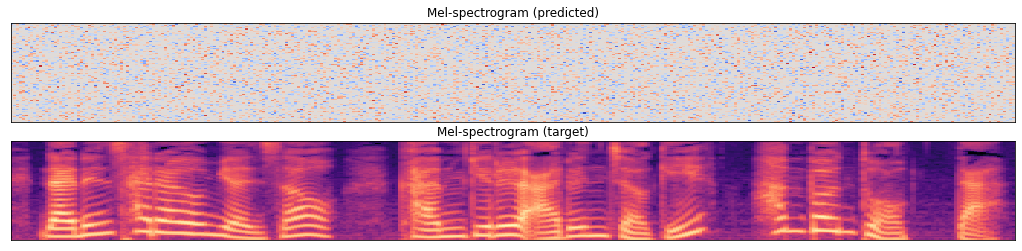

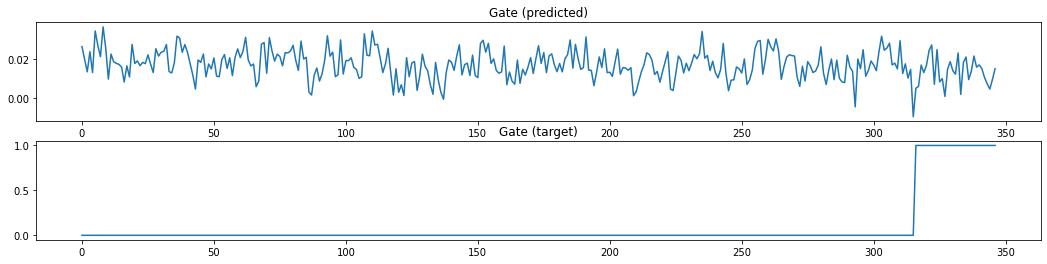

In [22]:
import matplotlib.pyplot as plt
import librosa.display

_mel_outputs_postnet = mel_outputs_postnet.data.cpu().numpy()
_gate_outputs = gate_outputs.data.cpu().numpy()
_mel_targets = y[0].data.cpu().numpy()
_gate_targets = y[1].data.cpu().numpy()

plt.figure(figsize=[18, 4])
plt.subplot(2, 1, 1)
plt.title('Mel-spectrogram (predicted)')
librosa.display.specshow(_mel_outputs_postnet[0])
plt.subplot(2, 1, 2)
plt.title('Mel-spectrogram (target)')
librosa.display.specshow(_mel_targets[0])
plt.show()

plt.figure(figsize=[18, 4])
plt.subplot(2, 1, 1)
plt.title('Gate (predicted)')
plt.plot(_gate_outputs[0])
plt.subplot(2, 1, 2)
plt.title('Gate (target)')
plt.plot(_gate_targets[1])
plt.show()

### Forward Propagation in Test

In [23]:
for batch in train_loader:
    model.eval()
    x, y = model.parse_batch(batch)
    
    with torch.no_grad():
        mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model(x)
    
    print(mel_outputs_postnet.shape)
    break

torch.Size([16, 80, 347])


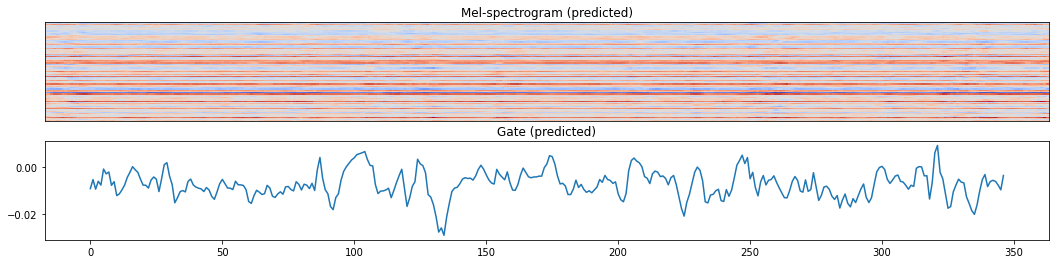

In [25]:
_mel_outputs_postnet = mel_outputs_postnet.data.cpu().numpy()
_gate_outputs = gate_outputs.data.cpu().numpy()

plt.figure(figsize=[18, 4])
plt.subplot(2, 1, 1)
plt.title('Mel-spectrogram (predicted)')
librosa.display.specshow(_mel_outputs_postnet[0])
plt.subplot(2, 1, 2)
plt.title('Gate (predicted)')
plt.plot(_gate_outputs[0])
plt.show()
